<a href="https://www.kaggle.com/code/dalloliogm/pgs5e8-bank-autogluon?scriptVersionId=257639017" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bank classification using Autogluon


Autogluon is a auto-ML library from Amazon. It can automatically try several approaches for prediction, and choose the optimal parameters given target metrics to optimize. It also automatically handles cross-validation, although that is not always enabled for all the presets.

Feel free to copy this notebook and adapt it. Some ideas on how to improve it:
- add more feature engineering
- Try different autogluon presets, or run it for longer
- Tweak the autogluon hyperparameters to add/remove more models
- Plot results and inspect them

## Install Libraries and set Configuration

Installing Autogluon takes time, on Kaggle, but once that is done, we don't need anything else.

In [1]:
# %%capture
# !pip install -U autogluon

In [2]:
%%capture
!pip install -q xgboost==1.7.6 scikit-learn==1.3.2

In [3]:
%%capture
import os
import shutil
import seaborn as sns

target_dir = "/kaggle/working/"
source_dir = "/kaggle/input/autogluon-package/"

if not os.path.exists(os.path.join(target_dir, "autogluon")):
    shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)
    print("Copied autogluon installation files.")

!pip install -f --quiet --no-index --find-links='/kaggle/input/autogluon-package' 'autogluon.tabular-1.3.1-py3-none-any.whl'


In [4]:
# Autogluon configuration. Automatically detects if we are using an interactive notebook, and use lower defaults when debugging
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

def is_interactive_session():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'

is_interactive_session()

config = {
    #                  minutes     seconds       # hours
    "autogluon_time": 60       *  60        *   8,
    "autogluon_preset": "best_quality",
    #"reduce_features": 0, # Set to >0 to use only the first n features
    "tail_rows": 0 # Set to >0 to use only the last n rows in the file. Useful for debugging
    
}

if is_interactive_session():
    print("Interactive session")
    config["autogluon_time"] = 100
    #config["reduce_features"] = 200
    config["autogluon_preset"] = "medium_quality"
    config["tail_rows"] = 2000
    print(config)
else:
    print("running as job")
    print(config)

running as job
{'autogluon_time': 28800, 'autogluon_preset': 'best_quality', 'tail_rows': 0}


In [5]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Autogluon parameters

In [6]:
hyperparameters = {
    'GBM': {},      # LightGBM
    'CAT': {},      # CatBoost
    'RF': {},       # RandomForest
    'XT': {},       # ExtraTrees
    'KNN': {},      # k-NN
    # 'NN': {},       # MXNet neural-net
    'LR': {},       # LinearModel
    'XGB': {        # XGBoost 
    },
    'TABPFN': {},
    'ENS_WEIGHTED' : {},
    "SIMPLE_ENS_WEIGHTED": {},
    'NN_TORCH': {},
    'IM_BOOSTEDRULES' : {},
    'IM_RULEFIT': {}
}

# 'RF', 'XT', 'KNN', 'GBM', 'CAT', 'XGB', 'NN_TORCH', 'LR', 'FASTAI', 'AG_TEXT_NN', 'AG_IMAGE_NN', 
# 'AG_AUTOMM', 'FT_TRANSFORMER', 'TABPFN', 'TABPFNMIX', 'FASTTEXT', 'ENS_WEIGHTED', 'SIMPLE_ENS_WEIGHTED',
# 'IM_RULEFIT', 'IM_GREEDYTREE', 'IM_FIGS', 'IM_HSTREE', 'IM_BOOSTEDRULES', 'DUMMY']

## Load Data

In [7]:
import pandas as pd
# data
path        = '/kaggle/input/playground-series-s5e8/'
train       = pd.read_csv(path + 'train.csv',             index_col = 'id')
test        = pd.read_csv(path + 'test.csv',              index_col = 'id')
submission  = pd.read_csv(path + 'sample_submission.csv', index_col = 'id')

# Reduce dataset size for debugging
if config["tail_rows"] > 0:
    train = train.head(config["tail_rows"])

In [8]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [9]:
test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [10]:
submission.head

<bound method NDFrame.head of           y
id         
750000  0.5
750001  0.5
750002  0.5
750003  0.5
750004  0.5
...     ...
999995  0.5
999996  0.5
999997  0.5
999998  0.5
999999  0.5

[250000 rows x 1 columns]>

## Feature Engineering

Some FE suggested by ChatGPT

In [11]:
import numpy as np
import pandas as pd
import random

def engineer_features(df, seed=42, max_combinations=5, verbose=True):
    df = df.copy()
    random.seed(seed)
    np.random.seed(seed)

    created_features = []

    # --- 1. Domain-based feature engineering ---

    # Convert month string to number
    month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
    if 'month' in df.columns:
        df['month_num'] = df['month'].map(month_map)
        created_features.append('month_num')

    # Flag: previously contacted
    if 'pdays' in df.columns:
        df['previously_contacted'] = (df['pdays'] != -1).astype(int)
        created_features.append('previously_contacted')

    # Bucket balance into quartiles
    if 'balance' in df.columns and df['balance'].nunique() > 4:
        df['balance_bucket'] = pd.qcut(df['balance'], q=4, labels=False, duplicates='drop')
        created_features.append('balance_bucket')

    # Interaction: job + education
    if 'job' in df.columns and 'education' in df.columns:
        df['job_edu'] = df['job'].astype(str) + "_" + df['education'].astype(str)
        created_features.append('job_edu')

    # Campaign transforms
    if 'campaign' in df.columns:
        df['log_campaign'] = np.log1p(df['campaign'])
        df['is_first_contact'] = (df['campaign'] == 1).astype(int)
        created_features += ['log_campaign', 'is_first_contact']

    # Frequency encoding
    for col in ['job', 'poutcome']:
        if col in df.columns:
            freq = df[col].value_counts(normalize=True)
            df[f'{col}_freq'] = df[col].map(freq)
            created_features.append(f'{col}_freq')

    # --- 2. Randomized combinations ---

    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns='y', errors='ignore').columns.tolist()

    # Random categorical pair interactions
    cat_pairs = random.sample(
        [(a, b) for i, a in enumerate(categorical_cols) for b in categorical_cols[i+1:]],
        k=min(max_combinations, len(categorical_cols) * (len(categorical_cols) - 1) // 2)
    )
    for a, b in cat_pairs:
        new_col = f"{a}_{b}_combo"
        df[new_col] = df[a].astype(str) + "_" + df[b].astype(str)
        created_features.append(new_col)

    # Random numeric pair ratios
    num_pairs = random.sample(
        [(a, b) for i, a in enumerate(numerical_cols) for b in numerical_cols[i+1:] if a != b],
        k=min(max_combinations, len(numerical_cols) * (len(numerical_cols) - 1) // 2)
    )
    for a, b in num_pairs:
        new_col = f"{a}_over_{b}"
        with np.errstate(divide='ignore', invalid='ignore'):
            df[new_col] = df[a] / df[b]
            df[new_col] = df[new_col].replace([np.inf, -np.inf], np.nan).fillna(0)
        created_features.append(new_col)

    # Random numeric log transforms
    for col in random.sample(numerical_cols, min(len(numerical_cols), max_combinations)):
        df[f'{col}_log'] = np.log1p(df[col])
        created_features.append(f'{col}_log')

    if verbose:
        print(f"✅ Created {len(created_features)} engineered features.")

    return df


In [12]:
train_fe = engineer_features(train)
test_fe = engineer_features(test)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


✅ Created 23 engineered features.
✅ Created 23 engineered features.


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Set up Training

In [13]:
%%capture

predictor = TabularPredictor(
    label='y',
    problem_type='binary',
    eval_metric="roc_auc",
).fit(
    train_fe,
    hyperparameters=hyperparameters,
    time_limit=config["autogluon_time"],
    presets=config["autogluon_preset"],
    # ag_args_fit={'num_gpus': 1},
    verbosity=1,
    # keep_test_data=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250823_063212"
		No module named 'tabpfn'
		Input  contains NaN, infinity or a value too large for dtype('float32').
Detailed Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 2169, in _train_and_save
    model = self._train_single(**model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 2055, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, total_resources=total_resources, **model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/autogluon/core/models/abstract/abstract_model.py", line 1051, in fit
    out = s

In [14]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.969197,roc_auc,83.740357,20897.299827,0.124247,20.796103,3,True,8
1,CatBoost_BAG_L2,0.969124,roc_auc,81.606063,20793.750071,1.826376,6564.288637,2,True,6
2,LightGBM_BAG_L2,0.969057,roc_auc,81.789734,14312.215087,2.010047,82.753653,2,True,5
3,WeightedEnsemble_L2,0.968728,roc_auc,77.439988,13713.300555,0.122695,10.305443,2,True,4
4,LightGBM_BAG_L1,0.968542,roc_auc,74.643671,808.564587,74.643671,808.564587,1,True,1
5,CatBoost_BAG_L1,0.966786,roc_auc,2.673622,12894.430525,2.673622,12894.430525,1,True,2
6,XGBoost_BAG_L2,0.963049,roc_auc,82.998249,14722.451400,3.218562,492.989967,2,True,7
7,XGBoost_BAG_L1,0.938971,roc_auc,2.462394,526.466321,2.462394,526.466321,1,True,3


In [15]:
import matplotlib.pyplot as plt

# Compute and plot feature importance
importance_df = predictor.feature_importance(data=train_fe)


These features in provided data are not utilized by the predictor and will be ignored: ['job_education_combo']


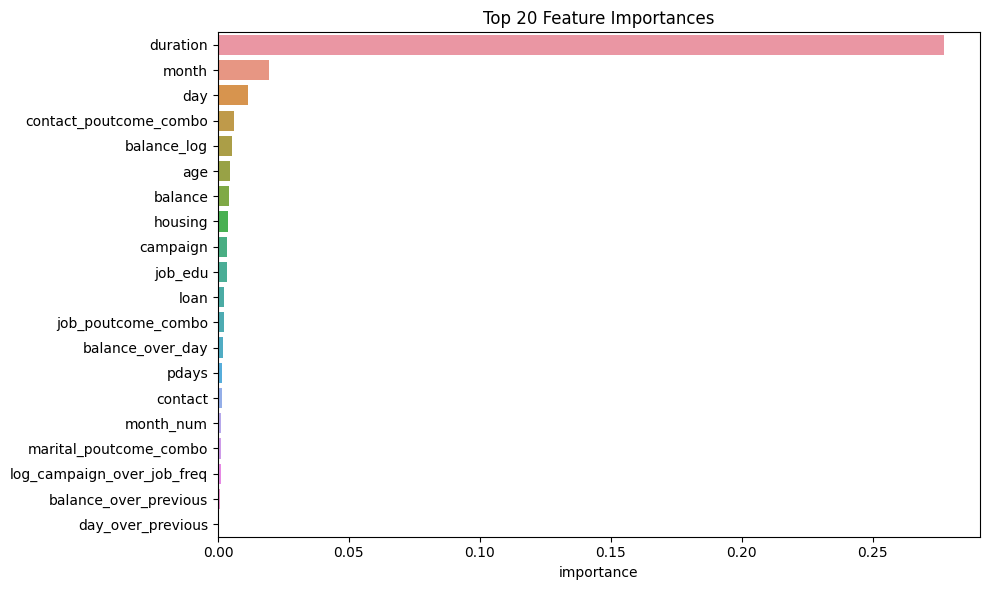

In [16]:
top_features = importance_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y=top_features.index)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Save Submission

In [17]:
%%capture
preds = predictor.predict_proba(test_fe)
preds

In [18]:
preds = predictor.predict_proba(test_fe)[1]
submission['y'] = preds
submission = submission.reset_index()
submission.to_csv('submission.csv', index=False)

## Prediction distributions

This dataset is unbalanced, as there about 3x 0s than 1s.

Autogluon should handle it automatically, although the predictions do not look very good, as they don't have the same distribution.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Observed Y')

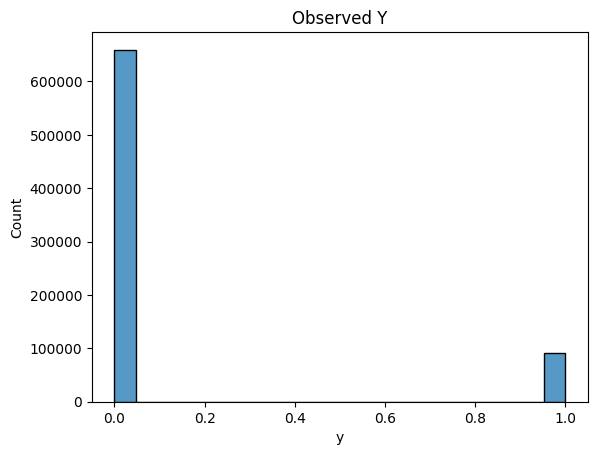

In [19]:
sns.histplot(train_fe.y).set_title("Observed Y")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Predicted Y')

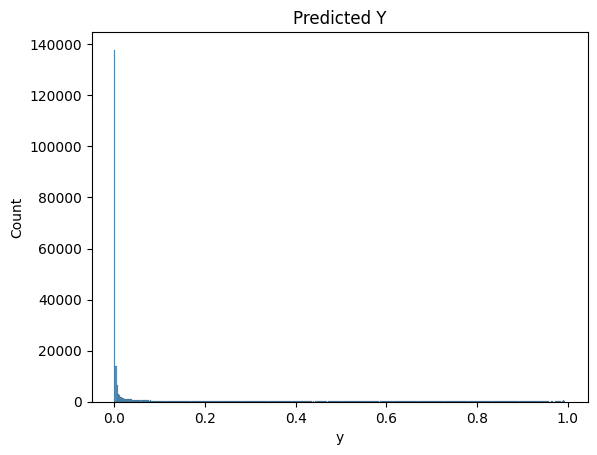

In [20]:
import seaborn as sns
sns.histplot(submission.y).set_title("Predicted Y")

## Evaluating overfitting

In [21]:
predictor.fit_summary()


*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val      fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L3   0.969197     roc_auc      83.740357  20897.299827                0.124247          20.796103            3       True          8
1      CatBoost_BAG_L2   0.969124     roc_auc      81.606063  20793.750071                1.826376        6564.288637            2       True          6
2      LightGBM_BAG_L2   0.969057     roc_auc      81.789734  14312.215087                2.010047          82.753653            2       True          5
3  WeightedEnsemble_L2   0.968728     roc_auc      77.439988  13713.300555                0.122695          10.305443            2       True          4
4      LightGBM_BAG_L1   0.968542     roc_auc      74.643671    808.564587               74.643671         808.564587            1       True          1
5      CatBoost_BAG_

{'model_types': {'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1': 0.9685416666396326,
  'CatBoost_BAG_L1': 0.9667858383158376,
  'XGBoost_BAG_L1': 0.9389712595675141,
  'WeightedEnsemble_L2': 0.9687280843239959,
  'LightGBM_BAG_L2': 0.9690567234905425,
  'CatBoost_BAG_L2': 0.9691238733070136,
  'XGBoost_BAG_L2': 0.9630489368778464,
  'WeightedEnsemble_L3': 0.9691971321079912},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'LightGBM_BAG_L1': ['LightGBM_BAG_L1'],
  'CatBoost_BAG_L1': ['CatBoost_BAG_L1'],
  'XGBoost_BAG_L1': ['XGBoost_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsemb

In [22]:
from sklearn.metrics import roc_auc_score

def check_overfitting(predictor, train_data, val_data=None, threshold=0.05):
    """
    Compare training and validation performance to detect overfitting.
    
    If bagging was used, computes out-of-fold (OoF) ROC AUC.
    If no val_data is provided, assumes OoF comparison only.
    """
    y_true = train_data['y']

    # Get train ROC AUC
    train_score = predictor.evaluate(train_data, silent=True)['roc_auc']

    if predictor._trainer.bagged_mode:
        # Use out-of-fold predictions for fair comparison
        oof_preds = predictor.get_oof_pred_proba(as_multiclass=False)[1]
        oof_score = roc_auc_score(y_true, oof_preds)
        score_gap = train_score - oof_score
        val_label = "Out-of-Fold"
    elif val_data is not None:
        val_score = predictor.evaluate(val_data, silent=True)['roc_auc']
        score_gap = train_score - val_score
        oof_score = val_score
        val_label = "Validation"
    else:
        print("❗ No validation data or bagging enabled. Can't assess overfitting.")
        return None

    print(f"Train ROC AUC:  {train_score:.4f}")
    print(f"{val_label} ROC AUC: {oof_score:.4f}")
    print(f"Gap:            {score_gap:.4f}")

    if score_gap > threshold:
        print("⚠️ Overfitting likely (gap > {:.2f})".format(threshold))
        return True
    elif score_gap < 0:
        print("✅ Generalization is good (val > train)")
        return False
    else:
        print("👌 Acceptable generalization")
        return False
#check_overfitting(predictor, train_fe)


### AUC plot

We plot the ROC Curve, although we use the train test, as cross validation is handled internally by Autogluon and we did not split train/test.



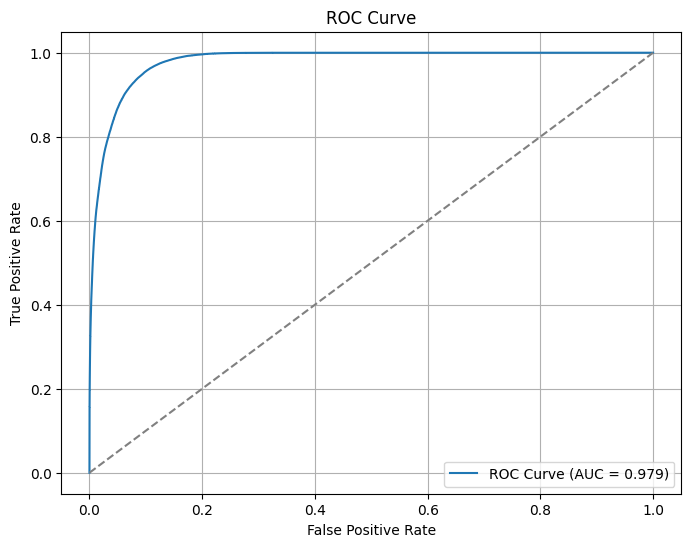

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Step 1: Get predicted probabilities (for class 1)
y_true = train_fe['y']
y_pred = predictor.predict_proba(train_fe.drop(columns=['y']))[1]

# Step 2: Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


## Cleanup

Delete all the files for installing Autogluon - let's save Kaggle a bit of disk storage costs.

In [24]:
if not is_interactive_session():
    os.system("rm -rf /kaggle/working/*")
    print("Clean-up complete: deleted files from /kaggle/working/")
else:
    print("Not an interactive session. Skipping clean-up.")

Clean-up complete: deleted files from /kaggle/working/


In [25]:
# Save submission
submission.to_csv('submission.csv', index=False)